## Import modules and functions

In [33]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

## Define directory of images

In [34]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Fab_internalization/Fab_resurfacing_Nikon/' #master folder

## Make dictionary for storing results

In [35]:
results = {"filename":[],"exp":[],"coverslip":[],
           "Manual mask from matlab GUI":[],"bg sub int under mask":[]}
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    #if "analyse" in str(filelist[i]):
        if ("ignore" in str(filelist[i]))==False:
            if filelist[i].endswith(".nd2"): 
                results["filename"].append(filelist[i])
                results["coverslip"].append(filelist[i].split('/')[-2])
                results["exp"].append(filelist[i].split('/')[-4])

## Read manual masks from Matlab GUI

In [36]:
## matlab files
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_dendritesmask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


## Batch analysis of images - mean intensity

In [37]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    flag=False
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[0]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    #read masks 
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    #image after background subtraction
    #for ecm image
    if flag==True:
        ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
        
    if flag==True:
        results["bg sub int under mask"].append(ecm_matlabmasked_bgreduced[matlab_mask].mean())
    else:
        results["bg sub int under mask"].append(np.nan)

Total number of images: 155
Calculating image no 1 out of155
Calculating image no 2 out of155
Calculating image no 3 out of155
Calculating image no 4 out of155
Calculating image no 5 out of155
Calculating image no 6 out of155
Calculating image no 7 out of155
Calculating image no 8 out of155
Calculating image no 9 out of155
Calculating image no 10 out of155
Calculating image no 11 out of155
Calculating image no 12 out of155
Calculating image no 13 out of155
Calculating image no 14 out of155
Calculating image no 15 out of155
Calculating image no 16 out of155
Calculating image no 17 out of155
Calculating image no 18 out of155
Calculating image no 19 out of155
Calculating image no 20 out of155
Calculating image no 21 out of155
Calculating image no 22 out of155
Calculating image no 23 out of155
Calculating image no 24 out of155
Calculating image no 25 out of155
Calculating image no 26 out of155
Calculating image no 27 out of155
Calculating image no 28 out of155
Calculating image no 29 out o

## Make a dataframe of the results

In [38]:
df["filename"].tolist()

['/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Fab_internalization/Fab_resurfacing_Nikon/20191224_recycling2/day0/20191223_recycling_d0_001.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Fab_internalization/Fab_resurfacing_Nikon/20191224_recycling2/day0/20191223_recycling_d0_002.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Fab_internalization/Fab_resurfacing_Nikon/20191224_recycling2/day0/20191223_recycling_d0_003.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Fab_internalization/Fab_resurfacing_Nikon/20191224_recycling2/day0/20191223_recycling_d0_004.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Fab_internalization/Fab_resurfacing_Nikon/20191224_recycling2/day0/20191223_recycling_d0_005.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Fab_internalization/Fab_resurfacing_Nikon/20191224_recycling2/day0/20191223_recycling_d0_006.nd2',
 '/Volumes/ukps-all$/user/tdanko/Imaging

In [39]:
df=pd.DataFrame(results)
df2=deepcopy(df)
df2['Day']='None'
df2.loc[df2['filename'].str.contains('day0'), 'Day'] = '0'
df2.loc[df2['filename'].str.contains('day1'), 'Day'] = '1'
df2.loc[df2['filename'].str.contains('day2'), 'Day'] = '2'
df2.loc[df2['filename'].str.contains('day3'), 'Day'] = '3'

df2['Exp']='None'
df2.loc[df2['filename'].str.contains('recycling2'), 'Exp'] = '2'
df2.loc[df2['filename'].str.contains('recycling3'), 'Exp'] = '3'
df2.loc[df2['filename'].str.contains('recycling4'), 'Exp'] = '4'

In [40]:
var="bg sub int under mask" #change me

means={"expname":[],"Day":[],
      "intensity normd to day0":[]}

df2read=df2[df2["Exp"]!="2"]

for exp in df2read["Exp"].unique():
    dfcalc=df2read[df2read["Exp"]==exp]
    
    means["expname"].append(exp)
    means["Day"].append('0')
    dfcalc2=dfcalc[dfcalc["Day"]=="0"]
    ctrl_mean=dfcalc2[var].mean()
    print(ctrl_mean)
    means["intensity normd to day0"].append(1)
    
    means["expname"].append(exp)
    means["Day"].append('1')
    dfcalc2=dfcalc[dfcalc["Day"]=="1"]
    means["intensity normd to day0"].append(dfcalc2[var].mean()/ctrl_mean) 
    print(dfcalc2[var].mean()/ctrl_mean)
    
    means["expname"].append(exp)
    means["Day"].append('3')
    dfcalc2=dfcalc[dfcalc["Day"]=="3"]
    means["intensity normd to day0"].append(dfcalc2[var].mean()/ctrl_mean)
    print(dfcalc2[var].mean()/ctrl_mean)
    
   
dfmeans=pd.DataFrame(means)

54.956589183259695
2.678089728526279
1.1568039582341934
58.20544839616475
1.2110682036674933
1.8218544836863608
nan
nan
nan


'x1, x2 = 0,1\ny= 6.2\nh=0.05\ncol=\'black\'\nplt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)\nplt.text((x1+x2)*.5, y+h, "**", ha=\'center\', va=\'bottom\', color=col,size=24, weight=\'bold\')\n\nx1, x2 = 2,3\ny= 6.2\nh=0.05\ncol=\'black\'\nplt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)\nplt.text((x1+x2)*.5, y+h, "ns", ha=\'center\', va=\'bottom\', color=col,size=24, weight=\'bold\')\n\n\ndiri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"\nfig.savefig(diri+\'Figure6_clumps.svg\', bbox_inches=\'tight\', format=\'svg\')'

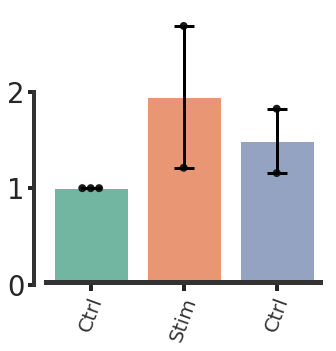

In [41]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker


var="intensity normd to day0"

fig=plt.figure(figsize=(5,5))
palette={"No clumps, ctrl": "#adadad",
         "No clumps, stim": "#adadad",
         "With clumps, ctrl":"#abc2fc",
         "With clumps, stim": "#abc2fc"
         }
order=["0","1","3"]

colorswarm={"No clumps, ctrl":"#333333",
            "No clumps, stim":"#333333",
            "With clumps, ctrl":"#2F67F8",
            "With clumps, stim":"#2F67F8"}

g=sns.swarmplot(data=dfmeans,y=var,x="Day",order=order,size=8,color='k')

g=sns.barplot(data=dfmeans,y=var,x="Day"
            ,order=order,ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[dfmeans[dfmeans["Day"]==condtype][var].mean() for condtype in order],
             yerr=[dfmeans[dfmeans["Day"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=10)
plt.xticks(g.get_xticks(),['Ctrl','Stim','Ctrl','Stim'],color='#333333',size=24)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),
          rotation=70,size=20)
g.grid(False)


'''x1, x2 = 0,1
y= 6.2
h=0.05
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 2,3
y= 6.2
h=0.05
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'Figure6_clumps.svg', bbox_inches='tight', format='svg')'''

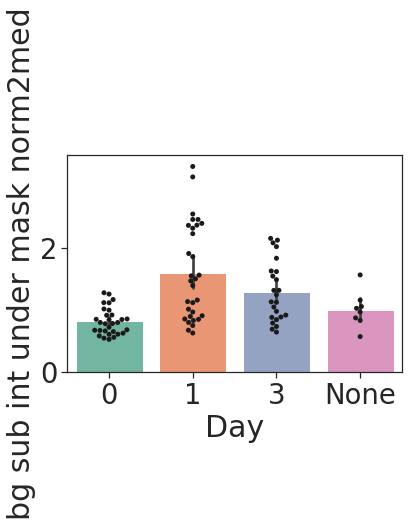

In [44]:
df2plot=df2[df2["Exp"]!="2"]
var="bg sub int under mask norm2med"
sns.barplot(x="Day",y=var,data=df2plot)
sns.swarmplot(x="Day",y=var,data=df2plot,color='k')

In [43]:
expnam=[]
medi=[]
for exp in df2["Exp"].unique():
    dfexp=df2[df2["Exp"]==exp]
    med=dfexp["bg sub int under mask"].median()
    expnam.append(exp)
    medi.append(med)
df2["bg sub int under mask norm2med"]=np.nan
for i in range(0,len(df2)):
    for j in range(0,len(expnam)):
        if df2["Exp"][i]==expnam[j]:
            df2["bg sub int under mask norm2med"][i]=df2["bg sub int under mask"][i]/medi[j]

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [ ]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

fig=plt.figure(figsize=(5,6))
df2plot=df2[df2["Blocked or not"]!="Unblocked"]
var="bg sub int under mask norm2med"
#var="ecm mean int norm2med"

order=['0',
       '1','3'
       ]

'''paletteswarm ={"Background - Autofluorescence":"#2F67F8",
               "Unblocked TNR647":"#333333",
               "Background - Atto647":"#2F67F8",
               "Block+0, TNR647":"#2F67F8",
               "Block+12, TNR647":"#2F67F8"}
palette ={"Background - Autofluorescence":"#abc2fc",
          "Unblocked TNR647":"#adadad",
               "Background - Atto647":"#abc2fc",
               "Block+0, TNR647":"#abc2fc",
               "Block+12, TNR647":"#abc2fc"}'''


g=sns.barplot(data=df2plot,y=var,x="Condition",
            order=order,color="#abc2fc",ci=None)

g=sns.swarmplot(data=df2plot,y=var,x="Condition",
            order=order,color="#2F67F8",size=8)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Condition"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Condition"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=4)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

plt.rcParams['font.sans-serif'] = 'Helvetica'


g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)


g.grid(False)


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)

plt.xticks(g.get_xticks(),order,
           rotation=75,size=24)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
#plt.yticks([0,2,4,6,8,10,12],fontsize=22,color='#333333')


scale_x=1
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
g.yaxis.set_major_formatter(ticks_y)

#plt.ylim([0,12.5])
x1, x2 = 0,1
y= 3.2
h=0.1
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 2,0
y= 4
h=0.1
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 3,0
y= 4.8
h=0.1
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'supp_ctrl_notpreexistingepitopes_.svg', bbox_inches='tight', format='svg')

In [ ]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

fig=plt.figure(figsize=(2,6))
df2plot=df2[df2["Blocked or not"]!="Unblocked"]
var="bg sub int under mask norm2med"
#var="ecm mean int norm2med"

order=['DMSO',
       'GM6001'
       ]

'''paletteswarm ={"Background - Autofluorescence":"#2F67F8",
               "Unblocked TNR647":"#333333",
               "Background - Atto647":"#2F67F8",
               "Block+0, TNR647":"#2F67F8",
               "Block+12, TNR647":"#2F67F8"}
palette ={"Background - Autofluorescence":"#abc2fc",
          "Unblocked TNR647":"#adadad",
               "Background - Atto647":"#abc2fc",
               "Block+0, TNR647":"#abc2fc",
               "Block+12, TNR647":"#abc2fc"}'''


g=sns.barplot(data=df2plot,y=var,x="Condition",
            order=order,color="#abc2fc",ci=None)

g=sns.swarmplot(data=df2plot,y=var,x="Condition",
            order=order,color="#2F67F8",size=8)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Condition"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Condition"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=4)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

plt.rcParams['font.sans-serif'] = 'Helvetica'


g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)


g.grid(False)


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)

plt.xticks(g.get_xticks(),order,
           rotation=75,size=24)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
#plt.yticks([0,2,4,6,8,10,12],fontsize=22,color='#333333')


scale_x=1
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
g.yaxis.set_major_formatter(ticks_y)

#plt.ylim([0,12.5])
x1, x2 = 0,1
y= 1.65
h=0.05
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')



diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'supp_ctrl_notpreexistingepitopes_gm6001.svg', bbox_inches='tight', format='svg')

## find representative pics

In [ ]:
num

In [19]:
df_pic=df2#[df2["Exp"]!="2"]


df_pic

,filename,exp,coverslip,Manual mask from matlab GUI,bg sub int under mask,Day,Exp,bg sub int under mask norm2med


In [20]:

df_pic=df2[df2["Exp"]!="2"]

df0=df_pic[df_pic["Day"]=="0"]
df1=df_pic[df_pic["Day"]=="1"]
df2=df_pic[df_pic["Day"]=="2"]




df_2show=df0
df_2show=df_2show.reset_index(drop=True)

minval=0
maxval=10000
num=1
leng=len(df_2show)
fig=plt.figure(figsize=(20,150))
for i in range(0,len(df_2show)):
    #print(i)
    fig.add_subplot(leng,1,num)
    with ND2Reader(df_2show["filename"][i]) as images:
        ecm_image=images[0]
        plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=minval,vmax=maxval)
        plt.title(df_2show["filename"][i][-40:], size=14)
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        plt.grid(visible=False)
        plt.axis(visible=False)
        #scalebar = ScaleBar(107.1, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
        #                       font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
        #plt.gca().add_artist(scalebar)
        num+=1
    

<Figure size 1440x10800 with 0 Axes>

In [21]:
df2.head()

,filename,exp,coverslip,Manual mask from matlab GUI,bg sub int under mask,Day,Exp,bg sub int under mask norm2med
